In [1]:
import sys
import numpy as np
import os
from torch.utils.data import DataLoader

if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

import torch
import matplotlib.pyplot as plt
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
print(torch.__file__)
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


c:\Users\luca-\OneDrive\Desktop\University\#MAGISTRALE\2 ANNO\1 SEMESTRE\DEEP LEARNING\project\informer_project_dl\.venv\lib\site-packages\torch\__init__.py
Torch version: 1.10.2+cu113
CUDA available: True


Iper-Parametri dell' Informer

In [2]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'ETTh1' # data
args.root_path = './data/ETDataset/ETT-small/' # root path of data file
args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
#args.target = 'OT' # target feature in S or MS task
args.target = 'OT'
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [4]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

Preparazione Dataset e settaggio finale modello

In [3]:
# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]
    
args.detail_freq = args.freq
args.freq = args.freq[-1:]

print('Args in experiment:')
print(args)

Exp = Exp_Informer

Args in experiment:
{'model': 'informer', 'data': 'ETTh1', 'root_path': './data/ETDataset/ETT-small/', 'data_path': 'ETTh1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 6, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [4]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)

    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 8521
val 2857
test 2857
	iters: 100, epoch: 1 | loss: 0.4132342
	speed: 0.1958s/iter; left time: 293.1090s
	iters: 200, epoch: 1 | loss: 0.2832627
	speed: 0.1415s/iter; left time: 197.7012s
Epoch: 1 cost time: 43.128788471221924
Epoch: 1, Steps: 266 | Train Loss: 0.4043628 Vali Loss: 0.7112313 Test Loss: 0.5310553
Validation loss decreased (inf --> 0.711231).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.2442193
	speed: 0.3104s/iter; left time: 382.0686s
	iters: 200, epoch: 2 | loss: 0.2459477
	speed: 0.1410s/iter; left time: 159.4489s
Epoch: 2 cost time: 37.56857466697693
Epoch: 2, Steps: 266 | Train Loss: 0.2537085 Vali Loss: 0.6532323 Test Loss: 0.5825031
Validation loss decreased (0.711231 --> 0.653232).  Saving model ...
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | l

In [5]:
def save_trained_model(exp, setting):
    """
    Salva il modello addestrato in un file locale.
    """
    # Path per salvare il modello
    save_path = os.path.join(exp.args.checkpoints, setting)
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Salvataggio del modello
    model_file = os.path.join(save_path, 'trained_model.pth')
    torch.save(exp.model.state_dict(), model_file)
    print(f"Modello salvato con successo: {model_file}")

# set saved model path
setting = 'informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

exp = Exp(args)

#save_trained_model(exp, setting)


Use GPU: cuda:0


In [ ]:

save_trained_model(exp, setting)

PREDICTION

Use GPU: cuda:0
pred 1
test 2857
test shape: (89, 32, 24, 7) (89, 32, 24, 7)
test shape: (2848, 24, 7) (2848, 24, 7)
mse:0.5392494201660156, mae:0.5271879434585571
Shape predizioni: (2848, 24, 7)
Shape ground truth: (2848, 24, 7)


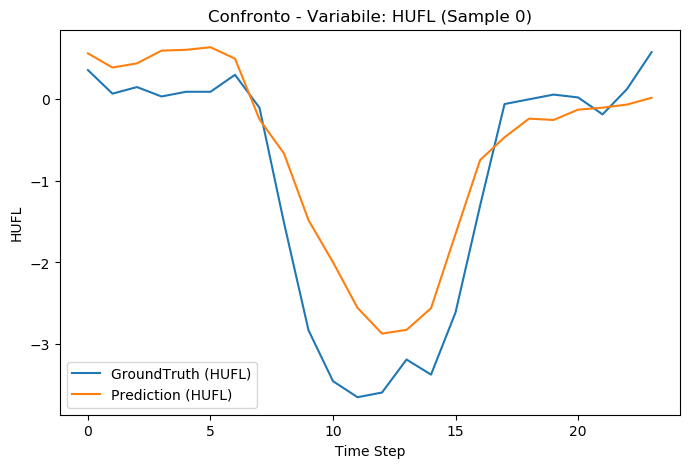

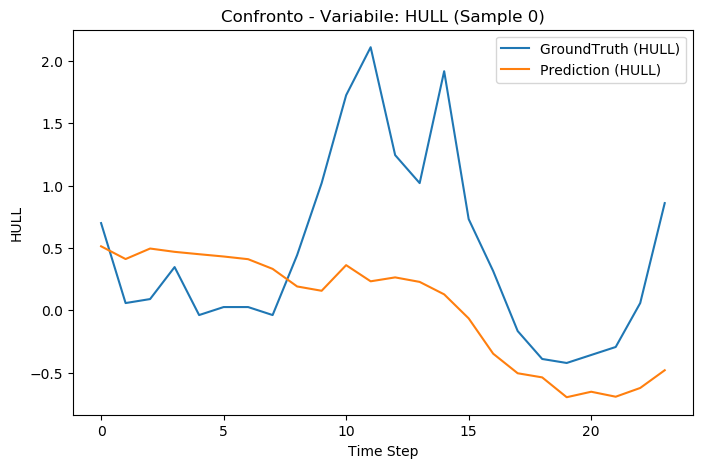

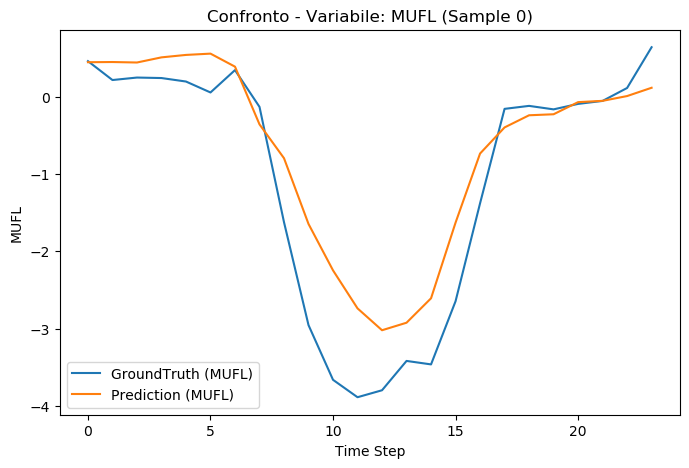

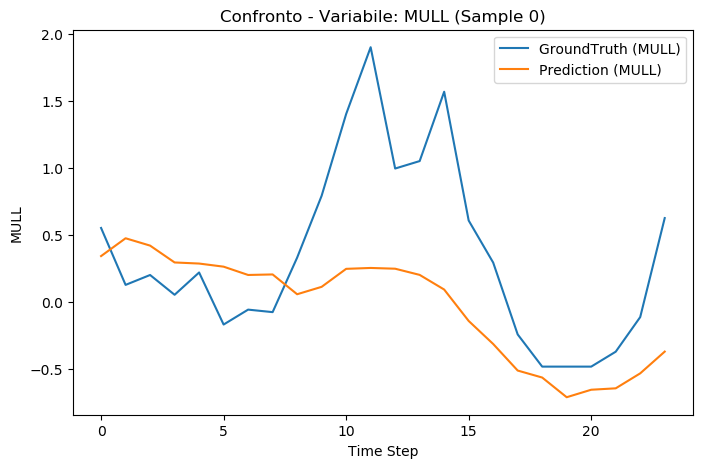

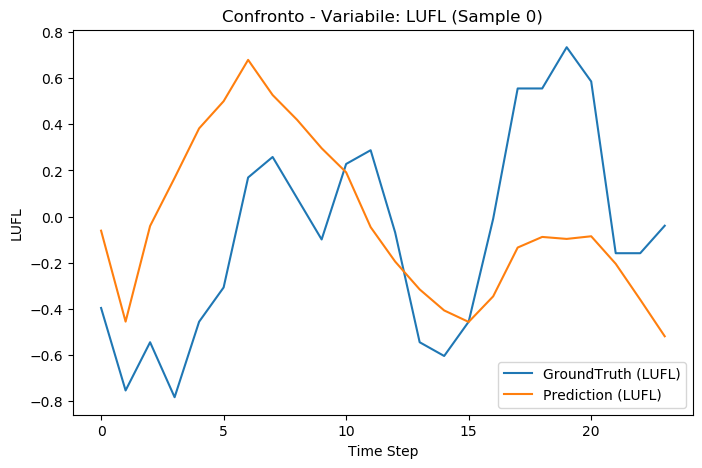

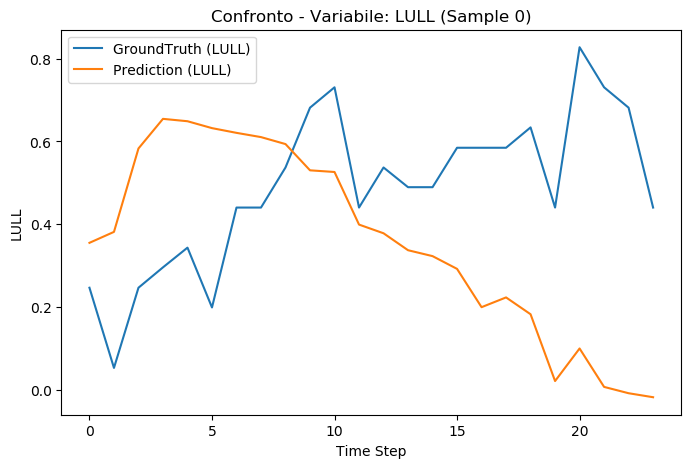

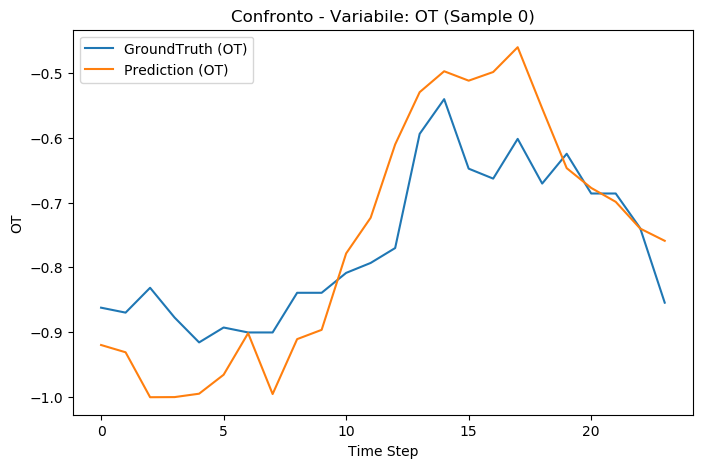

In [6]:

########################################
# 2) Istanzia Exp_Informer
Exp = Exp_Informer
exp = Exp(args)

exp.predict(setting, True)

prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape

setting = 'informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
model_file = os.path.join(args.checkpoints, setting, 'checkpoint.pth')
# o 'trained_model.pth' se quello è il checkpoint migliore

# 3) Carica i pesi
exp.model.load_state_dict(torch.load(model_file, map_location='cpu'))
if args.use_gpu:
    exp.model.cuda()
exp.model.eval()

# 4) Richiama test(...) 
#    Questo creerà i file pred.npy e true.npy in ./results/{setting}/
exp.test(setting)  

# 5) Carica i file generati
preds = np.load(f'./results/{setting}/pred.npy')
trues = np.load(f'./results/{setting}/true.npy')

print("Shape predizioni:", preds.shape)
print("Shape ground truth:", trues.shape)

# Nomi delle variabili (nel dataset)
variables = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

# Plot per ogni variabile
for i, var_name in enumerate(variables):
    idx_sample = 0  # Cambia questo per vedere altri esempi
    plt.figure(figsize=(8, 5))
    plt.plot(trues[idx_sample, :, i], label=f'GroundTruth ({var_name})')
    plt.plot(preds[idx_sample, :, i], label=f'Prediction ({var_name})')
    plt.title(f'Confronto - Variabile: {var_name} (Sample {idx_sample})')
    plt.xlabel('Time Step')
    plt.ylabel(var_name)
    plt.legend()
    plt.show()

In [7]:
# Funzioni metriche
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

# Analisi prestazioni per ogni variabile
variables = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

for i, var_name in enumerate(variables):
    y_true = trues[:, :, i].flatten()  # Ground truth per la variabile i
    y_pred = preds[:, :, i].flatten()  # Predizioni per la variabile i
    
    print(f"\n--- Metriche per la variabile: {var_name} ---")
    print(f"MAE : {mae(y_true, y_pred):.4f}")
    print(f"MSE : {mse(y_true, y_pred):.4f}")
    print(f"RMSE: {rmse(y_true, y_pred):.4f}")


--- Metriche per la variabile: HUFL ---
MAE : 0.7693
MSE : 1.0389
RMSE: 1.0193
MAPE: 304.46%
R^2 : 0.4009

--- Metriche per la variabile: HULL ---
MAE : 0.4415
MSE : 0.3339
RMSE: 0.5778
MAPE: 234.91%
R^2 : 0.0333

--- Metriche per la variabile: MUFL ---
MAE : 0.7348
MSE : 0.9905
RMSE: 0.9952
MAPE: 918.73%
R^2 : 0.4536

--- Metriche per la variabile: MULL ---
MAE : 0.3440
MSE : 0.2085
RMSE: 0.4567
MAPE: 6150.04%
R^2 : 0.2482

--- Metriche per la variabile: LUFL ---
MAE : 0.6552
MSE : 0.7478
RMSE: 0.8648
MAPE: 192.85%
R^2 : 0.0566

--- Metriche per la variabile: LULL ---
MAE : 0.4661
MSE : 0.3344
RMSE: 0.5783
MAPE: 229.64%
R^2 : -0.4700

--- Metriche per la variabile: OT ---
MAE : 0.2793
MSE : 0.1207
RMSE: 0.3474
MAPE: 20.93%
R^2 : -0.0335
